In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Custom dataset

In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode
import glob
from astropy.io import fits

def get_astro_dicts(img_dir):
    
    
    # It's weird to call this img_dir
    #set_dirs = glob.glob('%s/set_*' % img_dir)
    set_dirs = ['%s/set_%d' % (img_dir, i) for i in range(10)]
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts

# Register dataset
#yufeng 6/22
DatasetCatalog.register("astro_train", lambda: get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset"))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
astro_metadata = MetadataCatalog.get("astro_train")
DatasetCatalog.register("astro_val", lambda: get_astro_dicts("/home/yufengl2/astro_rcnn/testset"))
#change the above line to run on test/validation set
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
astro_metadata_val = MetadataCatalog.get("astro_val")

In [39]:
from detectron2.data import build_detection_train_loader

def read_image(filename, normalize='zscore', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 BGR image
    image[:,:,0] = g
    image[:,:,1] = r
    image[:,:,2] = z
    
    return image

### Visualize ground truth examples

149 instances
129 instances
125 instances


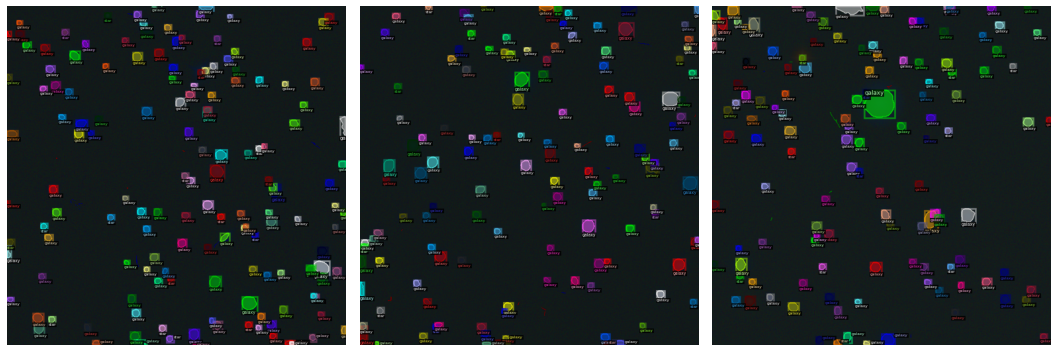

In [40]:
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset")

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d["file_name"], normalize="lupton", ceil_percentile=100)
    print(len(d['annotations']), "instances")
    visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

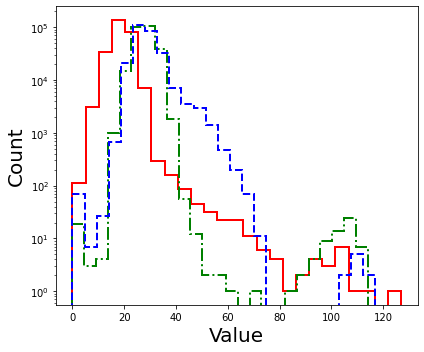

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1);
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2);
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3);
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
fig.tight_layout()

### Re-Train

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

"""train_mapper implements data augmentation, test_mapper does not"""
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"])
    augs = T.AugmentationList([
        T.RandomRotation([-90,90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    transform = augs(auginput) # remove this?
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

def test_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"])
    augs = T.AugmentationList([
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    transform = augs(auginput) # remove this?
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

### Visualize Augmented Data

/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/tensor_numpy.cpp:141.)


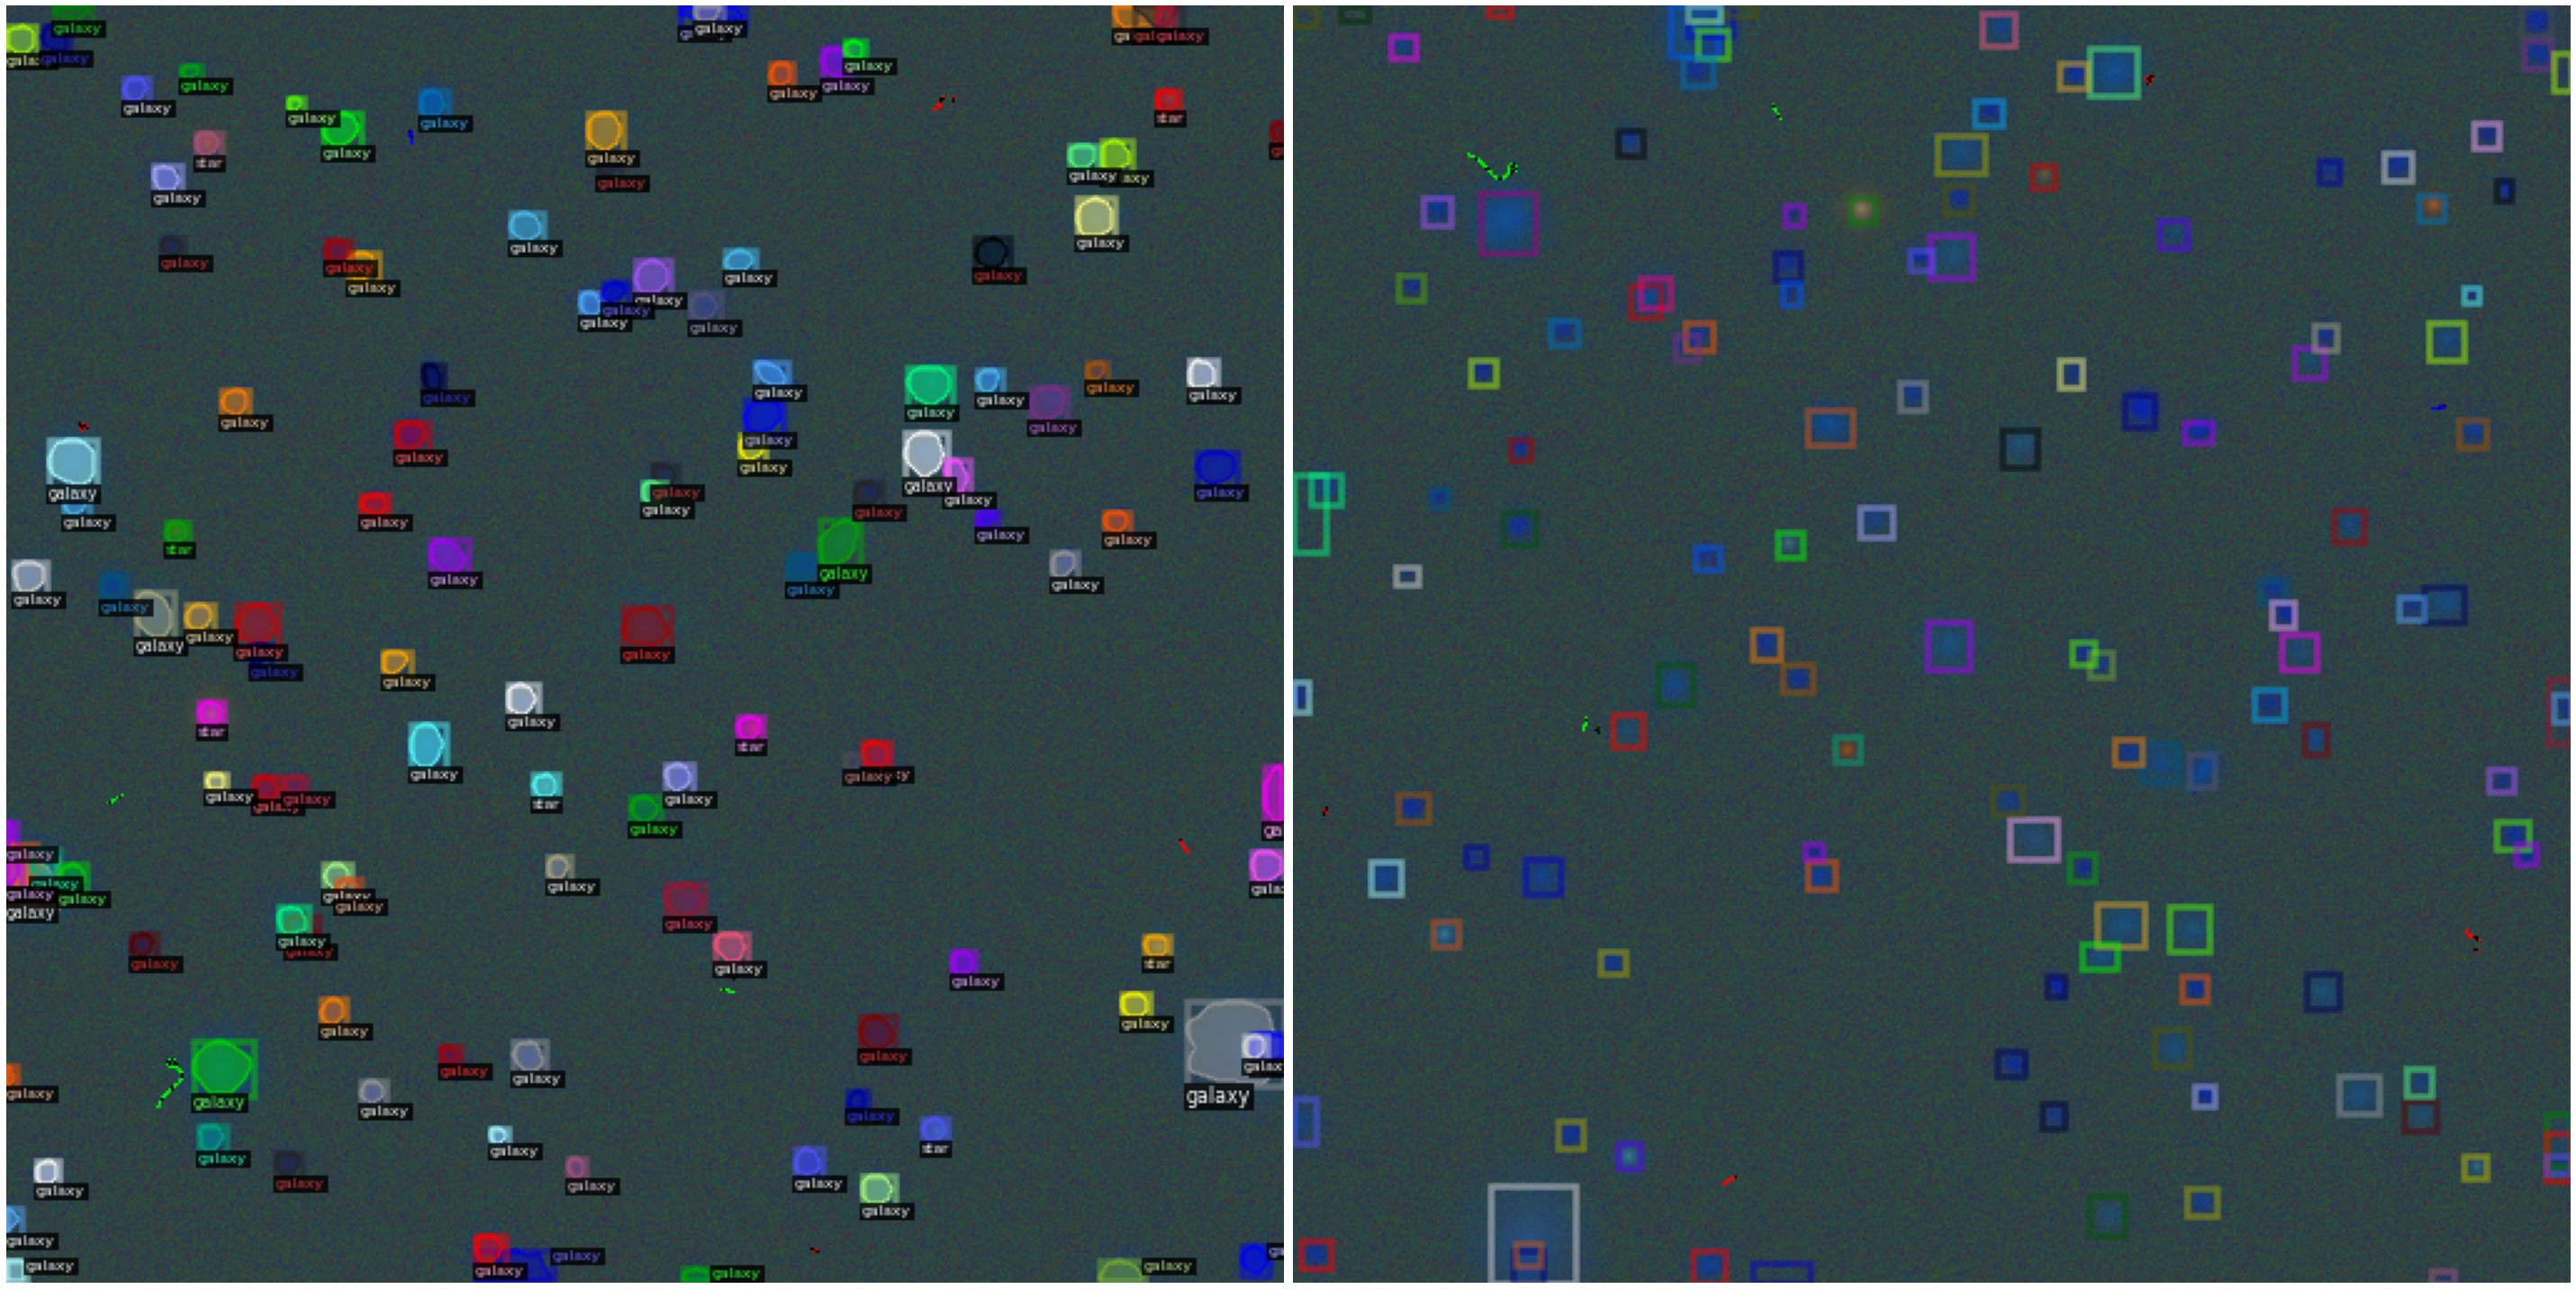

In [5]:
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset")
fig, axs = plt.subplots(1,2,figsize=(20*2, 20))

dictionary = iter(dataset_dicts)
d = next(dictionary)
img = read_image(d["file_name"], normalize="lupton")
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
out = visualizer.draw_dataset_dict(d)
axs[0].imshow(out.get_image())
axs[0].axis('off')
fig.tight_layout()
fig.show()

aug_data = train_mapper(d)
img_aug = aug_data["image"]
img_reshape = torch.zeros((512,512,3))
for i in range(3):
    img_reshape[:,:,i]= img_aug[i,:,:]
visualizer = Visualizer(img_reshape, metadata=astro_metadata, scale=1)
out = visualizer.overlay_instances(boxes = aug_data["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

### Prepare For Training

In [5]:
"""SaveHook is in charge of saving the trained model"""
class SaveHook(HookBase):
    def after_train(self):
        self.trainer.checkpointer.save("model_test_c4_zscore") # Set the name of the output model
class AstroTrainer(SimpleTrainer):
    def __init__(self, model, data_loader, optimizer):
        super().__init__(model, data_loader, optimizer)
        
        # Borrowed from DefaultTrainer constructor
        # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html#DefaultTrainer
        self.checkpointer = checkpointer.DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR
        )
        # load weights
        self.checkpointer.load(cfg.MODEL.WEIGHTS)
        
        # record loss over iteration 
        self.lossList = []
        
        self.period = 20
        self.iterCount = 0
    
    #print out loss
    def set_period(self,p):
        self.period = p
        
    # Copied directly from SimpleTrainer, add in custom manipulation with loss
    # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/train_loop.html#SimpleTrainer
    def run_step(self):
        self.iterCount = self.iterCount + 1
        assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        data_time = time.perf_counter() - start
        data = next(self._data_loader_iter)
        # Note: in training mode, model() returns loss
        loss_dict = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()
        self.lossList.append(losses)
        if self.iterCount % self.period == 0:
            print("Iteration: ", self.iterCount, " time: ", data_time," loss: ",losses)



In [21]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Register Metadata
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/home/yufengl2/astrodet2/astrodet/my_output/model_test_c4_zscore.pth'  #Let training initialize from a local model
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.000005  # pick a good LR#start from 0.005
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100    #for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = './my_output/'
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = SaveHook()
hookList = [saveHook]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)
print(type(optimizer))

[07/26 14:27:03 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[07/26 14:27:03 d2.data.build]: Using training sampler TrainingSampler
[07/26 14:27:03 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[07/26 14:27:03 d2.data.common]: Serialized dataset takes 0.16 MiB
<class 'torch.optim.sgd.SGD'>


In [22]:
trainer = AstroTrainer(model, loader, optimizer)
trainer.register_hooks(hookList)
trainer.set_period(50) # print loss every 25 iterations
trainer.train(0,3000) #100 iterations gives a loss roughly at 1.1



[07/26 14:27:03 d2.engine.train_loop]: Starting training from iteration 0


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/tensor_numpy.cpp:141.)
/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting 

Iteration:  50  time:  2.8405338525772095e-07  loss:  tensor(0.3078, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  100  time:  2.1909363567829132e-07  loss:  tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  150  time:  2.6798807084560394e-07  loss:  tensor(0.3130, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  200  time:  2.4097971618175507e-07  loss:  tensor(0.3030, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  250  time:  2.4796463549137115e-07  loss:  tensor(0.2799, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  300  time:  2.2584572434425354e-07  loss:  tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  350  time:  2.8102658689022064e-07  loss:  tensor(0.3034, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  400  time:  2.330634742975235e-07  loss:  tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  450  time:  2.1280720829963684e-07  loss:  tensor(0.3094, device='cuda:0', grad_fn=<AddBackward0>)
Ite

### Plot The Loss

[tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2257, device='cuda:0', grad_fn=<AddBackward0>)]

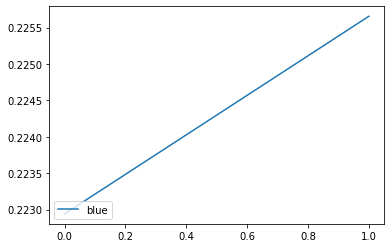

In [8]:
import matplotlib.pyplot as plt
import numpy as np
lossList = trainer.lossList #extract the loss
plt.plot(lossList)
plt.legend(['blue'], loc = 'lower left')
lossList[-10:] # print last 10 loss values

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

Launching TensorBoard...

KeyboardInterrupt: 

### Inference

In [23]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_test_c4_zscore.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

total instances: 164
detected instances: 136


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


total instances: 137
detected instances: 114
total instances: 120
detected instances: 116


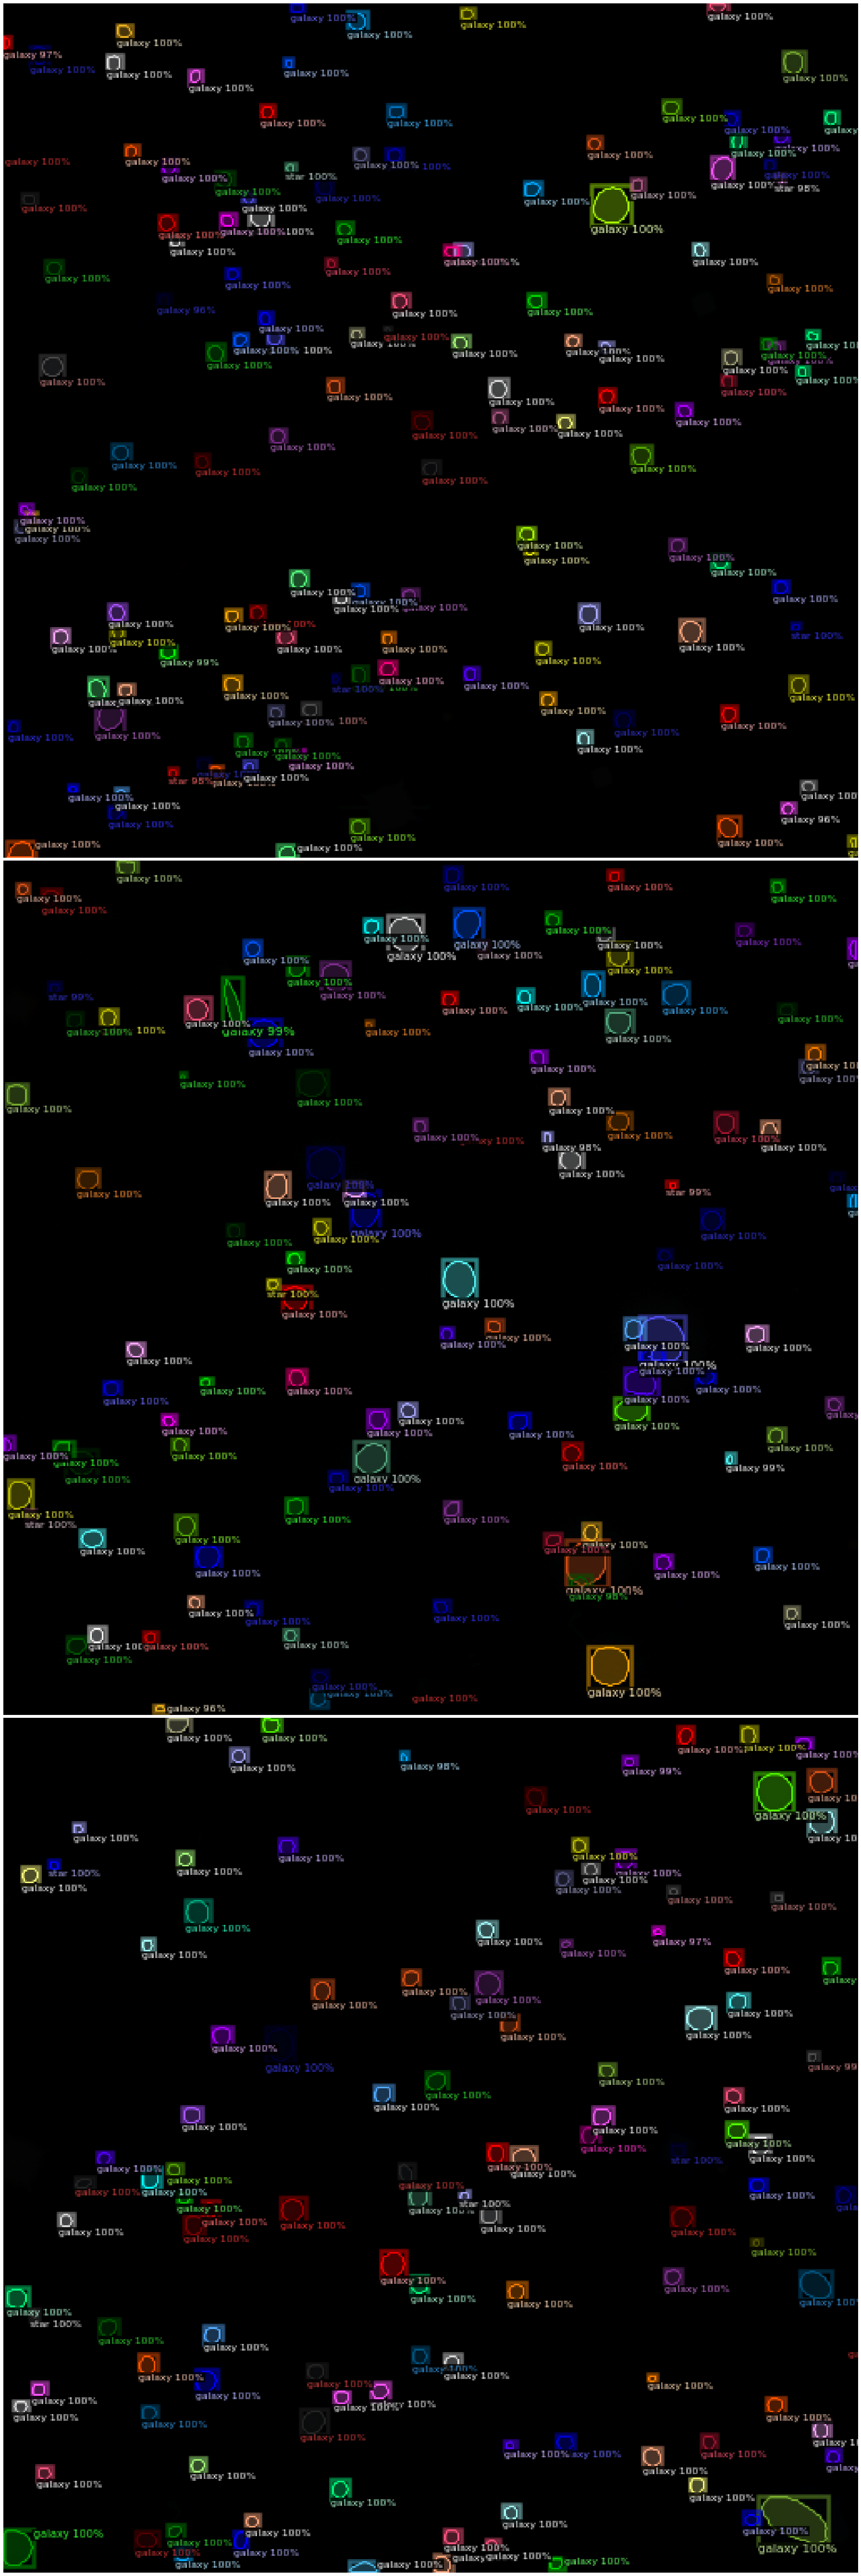

In [46]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/testset") # Replace this with the validation dataset

nsample = 3
fig, axs = plt.subplots(nsample, 1,figsize=(25, 25*nsample))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    print('total instances:', len(d['annotations']))
    im = read_image(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print('detected instances:',len(outputs['instances'].pred_boxes))
    v = Visualizer(np.log(im),
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [25]:
# Override COCOEvaluator to return precision-recall information
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
#yufeng 6/11 import cocoevaluator
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table

"""I override this function just to set maxDets to 200"""
def _evaluate_predictions_on_coco(
        coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
    ):
        
        #Evaluate the coco results using COCOEval API.
        assert len(coco_results) > 0
        print("_evaluate_predictions_on_coco")
        #6/27 this override function is not called
        if iou_type == "segm":
            coco_results = copy.deepcopy(coco_results)
            # When evaluating mask AP, if the results contain bbox, cocoapi will
            # use the box area as the area of the instance, instead of the mask area.
            # This leads to a different definition of small/medium/large.
            # We remove the bbox field to let mask AP use mask area.
            for c in coco_results:
                c.pop("bbox", None)
        
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)
        print(type(coco_eval))
        if img_ids is not None:
            coco_eval.params.imgIds = img_ids
            
        
        if iou_type == "keypoints":
            # Use the COCO default keypoint OKS sigmas unless overrides are specified
            if kpt_oks_sigmas:
                assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
                coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
            # COCOAPI requires every detection and every gt to have keypoints, so
            # we just take the first entry from both
            num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
            num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
            num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
            assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
                f"[COCOEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
                f"Ground truth contains {num_keypoints_gt} keypoints. "
                f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
                "They have to agree with each other. For meaning of OKS, please refer to "
                "http://cocodataset.org/#keypoints-eval."
            )
        coco_eval.params.maxDets = [1,10,200] # by default it is [1,10,100], our datasets have more than 100 instances
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        return coco_eval
    
    
    
class COCOEvaluatorRecall(COCOEvaluator):
    """This function is overrode in order to call the custom function above"""
    def _eval_predictions(self, predictions, img_ids=None):
        
        #Evaluate predictions. Fill self._results with the metrics of the tasks.
        
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            assert task in {"bbox", "segm", "keypoints"}, f"Got unknown task: {task}!"
            print(self._kpt_oks_sigmas)
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas = None,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res
            
    
    
    
    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        
        #Derive the desired score numbers from summarized COCOeval.

        """Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}"""
        
        print("++++++++derive_coco_results")
        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
            }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}
        # the standard metrics
        print(type(coco_eval))
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
            }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
            )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        precision_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            precision_per_category.append(precisions)
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
            )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)
        
        # Save the precision-recall per category
        results["results_per_category"] = precision_per_category

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluatorRecall("astro_val", cfg, False, output_dir="./my_output/") # Should be astro_val
val_loader = build_detection_test_loader(cfg, "astro_val", mapper=test_mapper) #It references to cfg.DATASETS.TEST
# dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/testset")
# val_loader = build_detection_test_loader(dataset_dicts, mapper=mapper)
#The two loader implementations are equivalent
results = inference_on_dataset(model, val_loader, evaluator) #yufeng 6/22  changed from trainer.model to model
#print(results)

WARNING [07/26 15:31:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/26 15:31:58 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[07/26 15:31:58 d2.data.common]: Serialized dataset takes 0.17 MiB
[07/26 15:31:58 d2.evaluation.evaluator]: Start inference on 10 images


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/tensor_numpy.cpp:141.)
/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting 

[07/26 15:32:00 d2.evaluation.evaluator]: Total inference time: 0:00:01.236336 (0.247267 s / img per device, on 1 devices)
[07/26 15:32:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.165796 s / img per device, on 1 devices)
[07/26 15:32:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/26 15:32:00 d2.evaluation.coco_evaluation]: Saving results to ./my_output/coco_instances_results.json
[07/26 15:32:00 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
[]
_evaluate_predictions_on_coco
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
<class 'detectron2.evaluation.fast_eval_api.COCOeval_opt'>
[07/26 15:32:00 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/26 15:32:00 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[07/26 15:32:00 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[07/26 15:32:00 d2.evaluation

In [26]:
results['segm'] # We can see the results_per_category has been added to the output

{'AP': nan,
 'AP50': 73.18363142222128,
 'AP75': 11.079726153249226,
 'APs': 27.716282427134963,
 'APm': 54.35643564356436,
 'APl': nan,
 'results_per_category': [array([[[[[ 1.        ,  1.        ,  1.        ],
            [ 1.        ,  1.        ,  1.        ],
            [-1.        , -1.        , -1.        ],
            [-1.        , -1.        , -1.        ]],
  
           [[ 1.        ,  1.        ,  1.        ],
            [ 1.        ,  1.        ,  1.        ],
            [ 0.        ,  0.        ,  1.        ],
            [-1.        , -1.        , -1.        ]]],
  
  
          [[[ 1.        ,  1.        ,  1.        ],
            [ 1.        ,  1.        ,  1.        ],
            [-1.        , -1.        , -1.        ],
            [-1.        , -1.        , -1.        ]],
  
           [[ 0.        ,  0.96666667,  0.97258297],
            [ 0.        ,  0.96666667,  0.9724238 ],
            [ 0.        ,  0.        ,  1.        ],
            [-1.        , -1

In [27]:
# Now get the precision
# precision has dims (iou, recall, cls, area range, max dets)
results_per_category = results['segm']['results_per_category']
#for ca in 
precision_star = results_per_category[0]
precision_galaxy = results_per_category[1]
print(np.shape(precision_star))
#print(precision_star)
print(precision_star[0,:,0,0,-1])

(10, 101, 2, 4, 3)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.98507463
 0.98507463 0.98507463 0.98507463 0.98507463 0.98507463 0.98507463
 0.98507463 0.98507463 0.98507463 0.98507463 0.98507463 0.98507463
 0.98507463 0.98507463 0.98507463 0.97368421 0.97368421 0.97368421
 0.97368421 0.97368421 0.97368421 0.96296296 0.96296296 0.96296296
 0.95402299 0.95402299 0.95402299 0.94382022 0.93814433 0.93814433
 0.93814433 0.93814433 0.92156863 0.92156863 0.91428571 0.91428571
 0.86725664 0.85344828 0.84745763 0.73571429 0.73571429 0.71428571
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

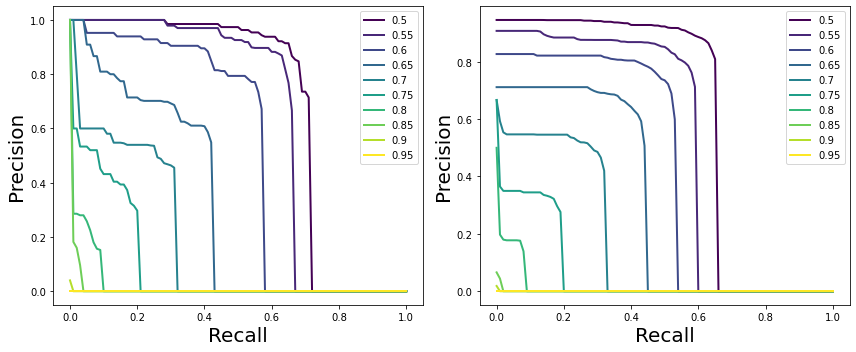

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))
#note: maxdet set to 2
# Plot precision recall
for j, precision_class in enumerate([precision_star, precision_galaxy]):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        # What are the IoU levels?
        p = precision_class[i, :, j, 0, -1]
        r = np.linspace(0, 1, precision_shape[1]) # i think
        mask = (p >-1)
        #redundant because p always>-1
        p = p[mask]
        r = r[mask]
        # Plot
        iou = np.around(ious[i], 2)
        #axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].legend(fontsize=10)
        
fig.tight_layout()